In [135]:
import wandb
api = wandb.Api()
runs = api.runs("vz_uci/lfiax_lf-pce_3D")

In [136]:
runs

<Runs vz_uci/lfiax_lf-pce_3D>

In [26]:
project_name = "my-project"

run_data = []
for run in runs:
    for file in run.files():
        # if file.type == "metadata":
        #     # Skip metadata files
        #     continue
        data = file.download(root="./downloads/")
        # print(dir(run_data))
        run_data.append({
            "run_id": run.id,
            "file_name": file.name,
            "file_data": data,
        })

CommError: File already exists, pass replace=True to overwrite or exist_ok=True to leave it as is and don't error.

In [17]:
type(runs)

wandb.apis.public.Runs

In [28]:
# Download all the files for each run
run_data = []
for run in runs:
    for file in run.files():
        # if file.type == "metadata":
        #     # Skip metadata files
        #     continue
        file_path = f"./downloads/{file.name}"
        if os.path.exists(file_path):
            # File already exists, skip downloading it
            continue
        try:
            data = file.download(root="./downloads/")
        except wandb.CommError as e:
            if "File already exists" in str(e):
                # File already exists, skip downloading it
                continue
            else:
                raise e
        run_data.append({
            "run_id": run.id,
            "file_name": file.name,
            "file_data": data,
        })


In [30]:
len(run_data)

10

In [33]:
import pandas as pd

df = pd.DataFrame(run_data)

In [38]:
df

,run_id,file_name,file_data
0,vti9vucv,conda-environment.yaml,<_io.TextIOWrapper name='./downloads/conda-env...
1,vti9vucv,config.yaml,<_io.TextIOWrapper name='./downloads/config.ya...
2,vti9vucv,output.log,<_io.TextIOWrapper name='./downloads/output.lo...
3,vti9vucv,requirements.txt,<_io.TextIOWrapper name='./downloads/requireme...
4,vti9vucv,wandb-metadata.json,<_io.TextIOWrapper name='./downloads/wandb-met...
5,vti9vucv,wandb-summary.json,<_io.TextIOWrapper name='./downloads/wandb-sum...
6,k81862ba,artifact/388642138/wandb_manifest.json,<_io.TextIOWrapper name='./downloads/artifact/...
7,drffv8ls,artifact/388642121/wandb_manifest.json,<_io.TextIOWrapper name='./downloads/artifact/...
8,5ydy3oon,artifact/388642145/wandb_manifest.json,<_io.TextIOWrapper name='./downloads/artifact/...
9,2ua46uq4,artifact/388623620/wandb_manifest.json,<_io.TextIOWrapper name='./downloads/artifact/...


In [39]:
# Extract the "xi" data from the log files
xi_data = pd.DataFrame()
for index, row in df.iterrows():
    # Split the log file into lines
    lines = row["log_data"].split("\n")
    for line in lines:
        # Check if the line contains "xi"
        if "xi" in line:
            # Extract the "xi" value from the line
            xi_value = line.split(" ")[-1]
            # Add the "xi" value to the DataFrame
            xi_data.loc[row["run_id"], len(xi_data.columns)] = float(xi_value)

# Print the "xi" data
print(xi_data)

KeyError: 'log_data'

In [137]:
run_data = []
for run in runs:
    log_file = None
    for file in run.files():
        # if file.type == "metadata":
        #     # Skip metadata files
        #     continue
        if file.name.endswith(".log"):
            # Save the path to the log file
            log_file = file.name
        # Download the file to the destination folder
        file.download(root="./downloads", exist_ok=True)
    if log_file is not None:
        # Read the contents of the log file into a Pandas DataFrame
        log_path = os.path.join("./downloads", log_file)
        log_data = pd.read_csv(log_path, delimiter="\t", names=["step", "key", "value"])
        xi_data = log_data[log_data["key"] == "xi"]
        xi_data = xi_data.drop(["key"], axis=1)
        xi_data = xi_data.rename(columns={"value": run.id})
        xi_data.set_index("step", inplace=True)
        run_data.append(xi_data)

# Concatenate the "xi" data from all runs into a single DataFrame
xi_data = pd.concat(run_data, axis=1)
runs_list = xi_data.columns.tolist()

# Print the "xi" data
print(xi_data)

Empty DataFrame
Columns: [wv11gi20, vmlaenxn, st0j07aw, pqtlrvli, ma8ed5a2, gf2s8arc, ga22dptz, 9mirs9mg, 9hy1ixq1, 7t6k656n, 6il08nqc, 5v9bqqtr, 5hgy65ao, 0ctdqru0, t7qjuwtc, qzaquzql, mvgzvpb7, lkfjflpb, g5wk86cy, a5ov2jp8, 84wzz122, 83hm1aqm, 5vrdr9hh, 2bvve01x, vti9vucv, qcfm7w12, 928mx08q, zfdpm9ye, wd3be2nt, uroq913x, uq05hd62, mxilke43, k81862ba, hkotq2bc, drffv8ls, do6dfs77, dc4brjqn, 91rovnay, 62682s91, 5ydy3oon, 55z8tajj, 4h5bnhzq, 1z8v8ma6, 1yf683j7, 1cfjacq8, ab2yi2rc, 2ua46uq4]
Index: []

[0 rows x 47 columns]


In [44]:
xi_data

,vti9vucv,qcfm7w12,928mx08q,zfdpm9ye,wd3be2nt,uroq913x,uq05hd62,mxilke43,k81862ba,hkotq2bc,...,91rovnay,62682s91,5ydy3oon,55z8tajj,4h5bnhzq,1z8v8ma6,1yf683j7,1cfjacq8,ab2yi2rc,2ua46uq4
step,,,,,,,,,,,,,,,,,,,,,


In [138]:
api = wandb.Api()

# List of runs (run IDs)
runs_list = xi_data.columns.tolist()

# Dictionary to store the data for each run
data_dict = {}

# Loop over the runs and get the data for each run
for run_id in runs_list:
    # Get the run object
    run = api.run(run_id)
    
    # Get the data associated with the "xi" key
    xi_data = run.history(keys=["xi"])
    # Add the data to the dictionary
    data_dict[run_id] = xi_data

# Combine the data for all runs into a single dataframe
df = pd.concat(data_dict.values(), keys=data_dict.keys(), names=["run_id", "step"])


CommError: Could not find run <Run vz_uci/wv11gi20/wv11gi20 (not found)>

In [139]:
entity = "vz_uci"
project = "lfiax_lf-pce_3D"

for run_id in runs_list:
    run = api.run(f"{entity}/{project}/{run_id}")
    # Get the data associated with the "xi" key
    xi_data = run.history(keys=["xi"])
    # Add the data to the dictionary
    data_dict[run_id] = xi_data

In [80]:
data_dict['vti9vucv'].shape

(500, 2)

In [79]:
len(xi_data)

500

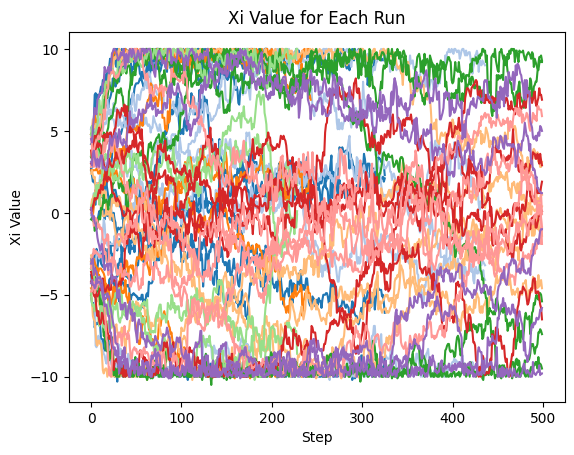

In [100]:
from itertools import islice

# Create a new dictionary that only contains the first 10 items of data_dict
last_10_items = dict(list(data_dict.items())[-10:])

fig, ax = plt.subplots()
ax.set_xlabel("Step")
ax.set_ylabel("Xi Value")
ax.set_title("Xi Value for Each Run")

# Plot the xi data for each run
colors = plt.cm.tab20(np.linspace(0, 1, len(data_dict)))
for i, (run, xi_data) in enumerate(last_10_items.items()):
    # Get the xi values as a 2-dimensional array
    xi_values = xi_data["xi"].values
    xi_values = np.vstack(xi_values)
    # xi_values = np.array([float(val) if isinstance(val, str) else val for val in xi_values[0]])
    xi_values = np.array([[float(val) if isinstance(val, str) else val for val in row] for row in xi_values])
    
    # Transpose the array so each of the 5 values is in a separate row
    xi_values = xi_values.T
    # Loop through each of the 5 values and plot a separate line for each
    for j in rang   e(xi_values.shape[0]):
        steps = list(range(len(xi_values[j])))
        ax.plot(steps, xi_values[j], color=colors[i], label=f"Run {run} ({j+1})")

# Add legend and show the plot
# ax.legend()
plt.show()

In [102]:
last_five = {k: v[-1:] for k, v in data_dict.items()}
last_five

{'vti9vucv':      _step                           xi
 499   9993  [[NaN, NaN, NaN, NaN, NaN]],
 'qcfm7w12':      _step                                                 xi
 499   9988  [[-1.3005709648132324, -2.1989569664001465, -0...,
 '928mx08q':      _step                           xi
 499   9983  [[NaN, NaN, NaN, NaN, NaN]],
 'zfdpm9ye':      _step                                                 xi
 499   9990  [[-5.001311302185059, 10, 9.2000093460083, 9.1...,
 'wd3be2nt':      _step                                                 xi
 499   9952  [[-2.2002625465393066, 0.3990784287452698, 3.7...,
 'uroq913x':      _step                                                 xi
 499   9931  [[-8.799710273742676, 0.8632327914237976, 0.09...,
 'uq05hd62':      _step                           xi
 499   9992  [[NaN, NaN, NaN, NaN, NaN]],
 'mxilke43':      _step                           xi
 499   9997  [[NaN, NaN, NaN, NaN, NaN]],
 'k81862ba':      _step                           xi
 499   9998

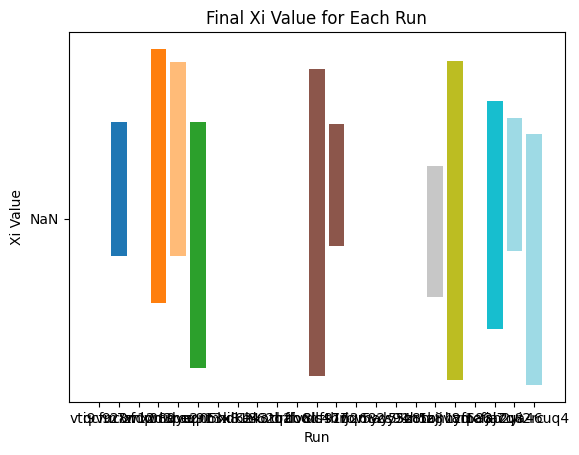

In [104]:
fig, ax = plt.subplots()
ax.set_xlabel("Run")
ax.set_ylabel("Xi Value")
ax.set_title("Final Xi Value for Each Run")

# Get the last xi value for each run
last_xi_values = {}
for run, xi_data in data_dict.items():
    last_xi_values[run] = xi_data.iloc[-1]["xi"]

# Plot the last xi values as a bar chart
colors = plt.cm.tab20(np.linspace(0, 1, len(last_xi_values)))
x_ticks = range(len(last_xi_values))
for i, (run, xi_values) in enumerate(last_xi_values.items()):
    ax.bar(i, xi_values[-1], color=colors[i], label=f"Run {run}")

# Set the x-ticks to the run names
ax.set_xticks(x_ticks)
ax.set_xticklabels(last_xi_values.keys())

# Add legend and show the plot
# ax.legend()
plt.show()


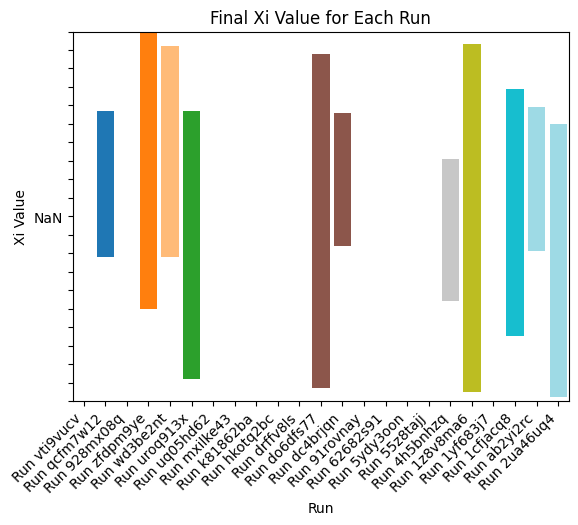

In [117]:
# Plot the last xi value for each run that doesn't have NaN values
fig, ax = plt.subplots()
ax.set_xlabel("Run")
ax.set_ylabel("Xi Value")
ax.set_title("Final Xi Value for Each Run")

# Keep track of the color index for each run
colors = plt.cm.tab20(np.linspace(0, 1, len(data_dict)))

# Keep track of the x position for each bar
x_pos = []

for i, (run, xi_data) in enumerate(data_dict.items()):
    # Check if the xi array for this run has any NaN values
    # if not np.isnan(xi_data.iloc[-1]["xi"]).any():
    # Get the last xi value for this run
    xi_values = xi_data.iloc[-1]["xi"]
    # Add the bar to the plot
    for j, xi_value in enumerate(xi_values):
        ax.bar(i, xi_value, color=colors[i], label=f"Run {run} ({j+1})")
    x_pos.append(i)

# Set the x-axis labels and limits
ax.set_xticks(x_pos)
ax.set_xticklabels([f"Run {run}" for run in data_dict.keys()])
plt.xticks(rotation=45, ha='right')
ax.set_xlim(-0.5, len(x_pos)-0.5)

ax.set_yticks(np.arange(-10, 11, 1))
ax.set_ylim(-10, 10)

# Add legend and show the plot
# ax.legend()
plt.show()


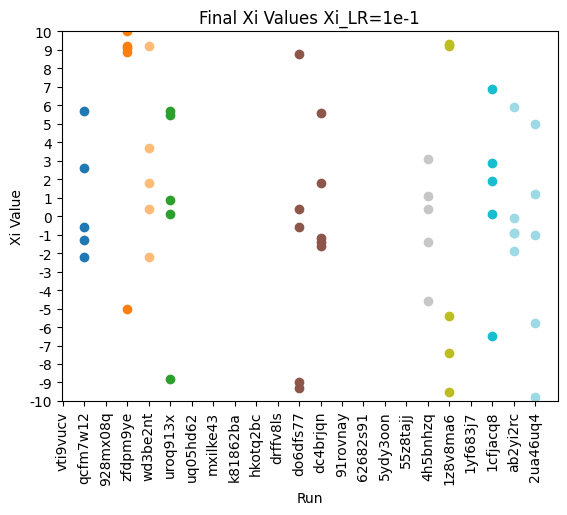

In [129]:
# Create a figure and axis for the plot
fig, ax = plt.subplots()
ax.set_xlabel("Run")
ax.set_ylabel("Xi Value")
ax.set_title("Final Xi Values Xi_LR=1e-1")

# Get a list of colors for each run
colors = plt.cm.tab20(np.linspace(0, 1, len(data_dict)))

# Loop through each run and plot the final xi value as a scatter point
for i, (run, xi_data) in enumerate(data_dict.items()):
    # Extract the final xi values from the history data
    xi_values = xi_data.iloc[-1]["xi"]
    # Convert any string values to floats
    xi_values = [float(val) if type(val) == str else val for val in xi_values]
    # Create a list of x-axis values with the same length as xi_values
    x_vals = [i] * len(xi_values[0])
    # Plot the xi value as a scatter point
    ax.scatter(x_vals, xi_values, color=colors[i], label=f"Run {run}")

# Set the x-tick labels to the run names
ax.set_xticks(list(range(len(data_dict))))
ax.set_xticklabels(list(data_dict.keys()), rotation=90)

# Set the y-axis limits and labels
ax.set_ylim(-10, 10)
ax.set_yticks(list(range(-10, 11)))
ax.set_yticklabels(list(range(-10, 11)))

# Add legend and show the plot
# ax.legend()
plt.show()


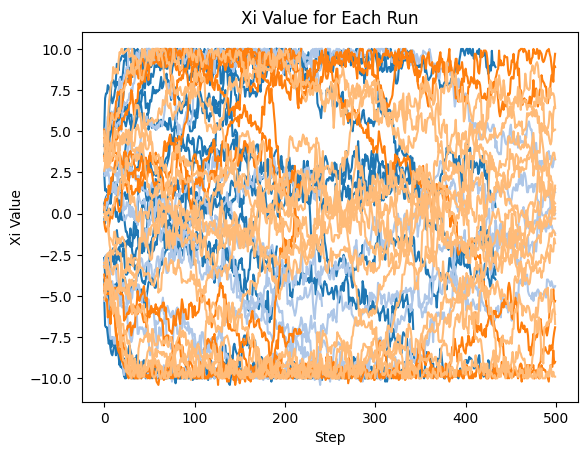

In [141]:
# Create a new dictionary that only contains the first 10 items of data_dict
last_10_items = dict(list(data_dict.items())[-10:])

fig, ax = plt.subplots()
ax.set_xlabel("Step")
ax.set_ylabel("Xi Value")
ax.set_title("Xi Value for Each Run")

# Plot the xi data for each run
colors = plt.cm.tab20(np.linspace(0, 1, len(data_dict)))
for i, (run, xi_data) in enumerate(last_10_items.items()):
    # Get the xi values as a 2-dimensional array
    xi_values = xi_data["xi"].values
    xi_values = np.vstack(xi_values)
    # xi_values = np.array([float(val) if isinstance(val, str) else val for val in xi_values[0]])
    xi_values = np.array([[float(val) if isinstance(val, str) else val for val in row] for row in xi_values])
    
    # Transpose the array so each of the 5 values is in a separate row
    xi_values = xi_values.T
    # Loop through each of the 5 values and plot a separate line for each
    for j in range(xi_values.shape[0]):
        steps = list(range(len(xi_values[j])))
        ax.plot(steps, xi_values[j], color=colors[i], label=f"Run {run} ({j+1})")

# Add legend and show the plot
# ax.legend()
plt.show()

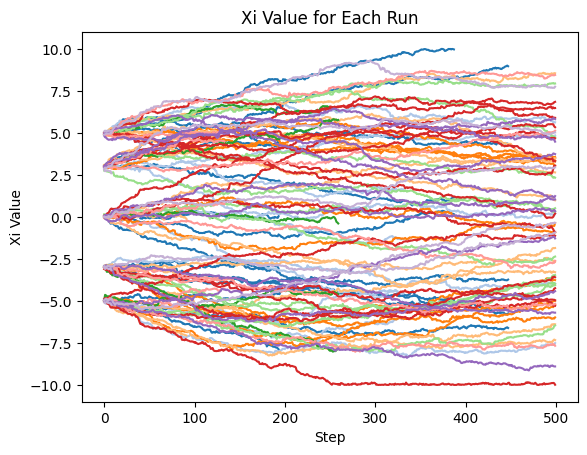

In [148]:
# Create a new dictionary that only contains the first 10 items of data_dict
last_10_items = dict(list(data_dict.items())[:23])

fig, ax = plt.subplots()
ax.set_xlabel("Step")
ax.set_ylabel("Xi Value")
ax.set_title("Xi Value for Each Run")

# Plot the xi data for each run
colors = plt.cm.tab20(np.linspace(0, 1, len(data_dict)))
for i, (run, xi_data) in enumerate(last_10_items.items()):
    # Get the xi values as a 2-dimensional array
    xi_values = xi_data["xi"].values
    xi_values = np.vstack(xi_values)
    # xi_values = np.array([float(val) if isinstance(val, str) else val for val in xi_values[0]])
    xi_values = np.array([[float(val) if isinstance(val, str) else val for val in row] for row in xi_values])
    
    # Transpose the array so each of the 5 values is in a separate row
    xi_values = xi_values.T
    # Loop through each of the 5 values and plot a separate line for each
    for j in range(xi_values.shape[0]):
        steps = list(range(len(xi_values[j])))
        ax.plot(steps, xi_values[j], color=colors[i], label=f"Run {run} ({j+1})")

# Add legend and show the plot
# ax.legend()
plt.show()

In [142]:
data_dict

{'wv11gi20':      _step                                                 xi
 0        1  [[-4.990000247955322, -2.9900009632110596, -0....
 1       12  [[-4.939999580383301, -2.9999961853027344, -0....
 2       13  [[-4.929999828338623, -2.9899961948394775, -0....
 3       30  [[-4.920000076293945, -2.9399962425231934, -0....
 4       31  [[-4.910000324249268, -2.9299962520599365, -0....
 ..     ...                                                ...
 495   9843                        [[NaN, NaN, NaN, NaN, NaN]]
 496   9869                        [[NaN, NaN, NaN, NaN, NaN]]
 497   9876                        [[NaN, NaN, NaN, NaN, NaN]]
 498   9916                        [[NaN, NaN, NaN, NaN, NaN]]
 499   9919                        [[NaN, NaN, NaN, NaN, NaN]]
 
 [500 rows x 2 columns],
 'vmlaenxn':      _step                                                 xi
 0        3  [[-4.9900007247924805, -2.970001697540283, -0....
 1        5  [[-4.970001220703125, -2.9700021743774414, -0....
 2  